## Today we will speak about text classification

**We will detect polarity of movie reviews, negative or positive.**

In [2]:
import requests
import urllib
from os.path import dirname, abspath, join, exists
import os
import tarfile
import argparse
from zipfile import ZipFile

In [3]:
# Download dataset.
dataset_dir = 'data/'
if not exists(dataset_dir):
    os.mkdir(dataset_dir)
dataset_url = 'https://www.cs.cornell.edu/people/pabo/movie%2Dreview%2Ddata/rt-polaritydata.tar.gz'
tar_file = 'rt-polaritydata.tar.gz'
tar_filepath = join(dataset_dir, tar_file)
urllib.request.urlretrieve(dataset_url, filename=tar_filepath)
with tarfile.open(tar_filepath, "r") as tar:
    tar.extractall(dataset_dir)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [5]:
neg_filepath = join(dataset_dir,'rt-polaritydata', 'rt-polarity.neg')
pos_filepath = join(dataset_dir,'rt-polaritydata', 'rt-polarity.pos')

In [6]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
# May be you will need to change chmod to nltk_data folder
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/vprov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
def clean_tokens(tokens):
    result = []
    for token in tokens:
        if token.isalpha() and not token in stop_words:
            result.append(token)
    return result

In [10]:
sentences = []
with open(pos_filepath, 'r', errors='ignore') as pos:
    for line in pos:
        words = clean_tokens(tokenizer.tokenize(line.lower()))
        sentences.append((words, 1))
with open(neg_filepath, 'r', errors='ignore') as neg:
    for line in neg:
        words = clean_tokens(tokenizer.tokenize(line.lower()))
        sentences.append((words, 0))
        
train_data, test_data = train_test_split(sentences, test_size=0.1)
train_data, val_data = train_test_split(train_data, test_size=0.2)
n_classes = 2

In [11]:
len(train_data), len(test_data)

(7676, 1067)

In [12]:
train_data[3]

(['pacing',
  'often',
  'way',
  'many',
  'bona',
  'fide',
  'groaners',
  'among',
  'laughs'],
 0)

In [13]:
for i in range(5):
    print(train_data[i])

(['connoisseurs', 'chinese', 'film', 'pleased', 'discover', 'tian', 'meticulous', 'talent', 'withered', 'enforced', 'hiatus'], 1)
(['enough', 'moments', 'heartbreaking', 'honesty', 'keep', 'one', 'glued', 'screen'], 1)
(['spoof', 'comedy', 'carries', 'share', 'laughs', 'sometimes', 'chuckle', 'sometimes', 'guffaw', 'great', 'pleasure', 'occasional', 'belly', 'laugh'], 1)
(['pacing', 'often', 'way', 'many', 'bona', 'fide', 'groaners', 'among', 'laughs'], 0)
(['first', 'two', 'thirds', 'sparklingly', 'inventive', 'artful', 'always', 'fast', 'furious', 'tale', 'kids', 'go', 'happily', 'along', 'ride'], 1)


**Task: watch balance of classes.**

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 
​
Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [14]:
from collections import Counter

In [15]:
word_list = []
for tokens in train_data:
    word_list += tokens[0]
for tokens in test_data:
    word_list += tokens[0]

In [16]:
len(word_list)

93414

**Well, there are quiet few words, so we do not need a complex model. In fact statistical models, for example TF-IDF may work better than NN on this task.**

In [17]:
token_counts = Counter(word_list)

In [18]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 16489
('film', 1288)
('movie', 1153)
('one', 645)
('like', 592)
('story', 389)
...
('golden', 1)
('eagle', 1)
('carpets', 1)


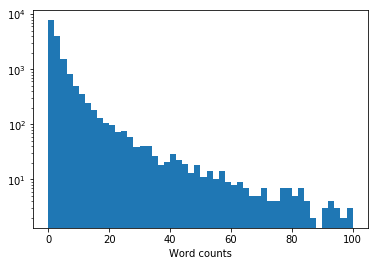

In [19]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**2], bins=50, log=True)
plt.xlabel("Word counts");

In [20]:
min_count = 5

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, n in token_counts.items() if n >= min_count]

In [21]:
len(tokens)

3780

In [22]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 3782


In [23]:
token_to_id = {}
for i, token in enumerate(tokens):
    token_to_id[token] = i

In [24]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [25]:
train_sentences = []
train_targets = []
for sent, target in train_data:
    train_sentences.append(sent)
    train_targets.append(target)

In [26]:
# Let's spare RAM.
del train_data

In [27]:
test_sentences = []
test_targets = []
for sent, target in test_data:
    test_sentences.append(sent)
    test_targets.append(target)

In [28]:
del test_data

In [29]:
train_sentences

[['connoisseurs',
  'chinese',
  'film',
  'pleased',
  'discover',
  'tian',
  'meticulous',
  'talent',
  'withered',
  'enforced',
  'hiatus'],
 ['enough',
  'moments',
  'heartbreaking',
  'honesty',
  'keep',
  'one',
  'glued',
  'screen'],
 ['spoof',
  'comedy',
  'carries',
  'share',
  'laughs',
  'sometimes',
  'chuckle',
  'sometimes',
  'guffaw',
  'great',
  'pleasure',
  'occasional',
  'belly',
  'laugh'],
 ['pacing',
  'often',
  'way',
  'many',
  'bona',
  'fide',
  'groaners',
  'among',
  'laughs'],
 ['first',
  'two',
  'thirds',
  'sparklingly',
  'inventive',
  'artful',
  'always',
  'fast',
  'furious',
  'tale',
  'kids',
  'go',
  'happily',
  'along',
  'ride'],
 ['personal',
  'velocity',
  'ought',
  'exploring',
  'women',
  'inner',
  'lives',
  'never',
  'moves',
  'beyond',
  'surfaces'],
 ['elements',
  'cribbed',
  'lang',
  'metropolis',
  'welles',
  'kane',
  'eisenstein',
  'potemkin',
  'true',
  'wonder',
  'rintar',
  'metropolis',
  'number'

In [30]:
def make_batch(sentences, targets, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    """
    batch = {}
    batch["text"] = as_matrix(sentences, max_len)
    batch['target'] = np.array(targets)
    
    return batch

In [31]:
make_batch(train_sentences[:10], train_targets[:10], max_len=10)

{'text': array([[   0,  522, 1250,    0,  894,    0,    0, 3313,    0,    0],
        [1063, 2139, 1538, 1588, 1815, 2300,    0, 2866,    1,    1],
        [3131,  598,  439, 2954, 1885, 3079,  536, 3079,    0, 1455],
        [2338, 2295, 3669, 2026,    0,    0,    0,  113, 1885,    1],
        [1270, 3504,    0,    0, 1751,    0,  100, 1209,    0, 3312],
        [2405, 3600, 2321,    0, 3733, 1701, 1951, 2228, 2167,  287],
        [1008,    0,    0, 2098,    0,    0,    0,    0, 3485, 3734],
        [2222, 2360,    0, 3507, 2780, 1889,  368, 1341, 2608,  494],
        [   0, 2208, 2397, 3110,    0, 3487, 2640, 2974,  144,    0],
        [1397,  327, 2332,    0, 2456, 3182, 3151, 2338,    1,    1]],
       dtype=int32), 'target': array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0])}

**Let's do the architecture**

In [32]:
import torch
from torch import nn

In [48]:
class ConvNet(nn.Module):
    def __init__(self,n_tokens=len(tokens), emb_size=20, 
                 kernel_sizes=[2,3,4]):
        super().__init__()
        ### YOUR CODE HERE
        
    def forward(self,batch):
        embeddings = self.embeddings(torch.LongTensor(batch['text']))
        embeddings = embeddings.transpose(1,2) # (batch_size, wordvec_size, sentence_length)
        
        feature_list = []
        for conv in self.conv_modules:
            ### YOUR CODE HERE
        features = torch.cat(feature_list, dim=1)
        features = self.drop(features)
        linear = self.linear(features)
        return linear
    
    def predict(self, batch):
        return self.softmax(self.forward(batch))

In [49]:
model = ConvNet()

In [50]:
model.forward(make_batch(train_sentences[:10], train_targets[:10], max_len=10))

tensor([[-0.4342, -0.1225],
        [-2.1199,  0.2693],
        [-0.5797,  0.0175],
        [-0.2312, -1.0688],
        [-0.6571, -0.1039],
        [-0.2441, -0.3575],
        [-0.1054, -0.2016],
        [-0.2882, -0.0516],
        [-0.6349,  0.8330],
        [-1.7101,  0.3878]], grad_fn=<ThAddmmBackward>)

In [51]:
optimizer = torch.optim.Adam(model.parameters())

In [59]:
from tqdm import tqdm_notebook
import random
batch_size=60
dataset_arange = np.arange(len(train_sentences))
num_iters = 1000

In [60]:
from torch.autograd import Variable

In [61]:
train_sentences = np.array(train_sentences)
train_targets = np.array(train_targets)

In [62]:
train_sentences.shape[0]

7676

In [63]:
loss_fn = nn.CrossEntropyLoss()

In [64]:
test_batch = make_batch(test_sentences, test_targets, max_len=10)

In [65]:
losses_train = []
losses_test = []
for i in tqdm_notebook(range(num_iters)):
    
    optimizer.zero_grad()
    index = np.random.choice(dataset_arange, size=batch_size)
    batch = make_batch(train_sentences[index], train_targets[index], max_len=10)
    output = model.forward(batch)
    loss = loss_fn(output, Variable(torch.LongTensor(batch['target'])))
    loss.backward()
    optimizer.step()
    if (i+10) % 100 == 0:
        losses_train.append(float(loss))
        output = model.forward(test_batch)
        test_loss = loss_fn(output, Variable(torch.LongTensor(test_batch['target'])))
        losses_test.append(float(test_loss))
    if (i+10) % 500 == 0:
        print("Train loss: ", losses_train[-1])
        print("Test loss: ", losses_test[-1])

Train loss:  0.5365133881568909
Test loss:  0.7018473148345947
Train loss:  0.46953219175338745
Test loss:  0.6834933757781982



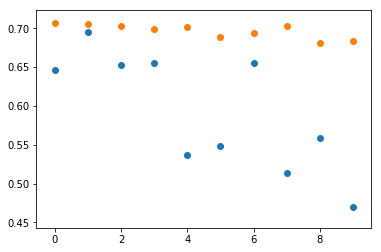

In [66]:
plt.scatter(np.arange(len(losses_train)), losses_train)
plt.scatter(np.arange(len(losses_test)), losses_test)

In [67]:
model.predict(make_batch(test_sentences[:10], test_targets[:10], max_len=10))

/home/vprov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.2594, 0.7406],
        [0.5381, 0.4619],
        [0.3982, 0.6018],
        [0.3533, 0.6467],
        [0.6483, 0.3517],
        [0.8039, 0.1961],
        [0.3150, 0.6850],
        [0.4915, 0.5085],
        [0.6051, 0.3949],
        [0.7818, 0.2182]], grad_fn=<SoftmaxBackward>)

In [68]:
predictions = model.predict(make_batch(test_sentences, test_targets, max_len=10))

/home/vprov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [69]:
predictions = np.argmax(predictions.detach().numpy(), axis=1)

In [70]:
from sklearn.metrics import accuracy_score

In [71]:
accuracy_score(test_targets, predictions)

0.6213683223992502

**Well, it is bad, in the original paper about CNNs https://arxiv.org/pdf/1408.5882.pdf the author achieves nearly 80 percents.**

**Hometask: Achive good accuracy with CNN models.**

## Homework, project part. If you do this part you do not need to do previous line (improve CNN accuracy)

### I want you to choose one topic:
#### Each task should be a class in python3, you can choose all over stuff by yourself. 

#### Also, if it is hard to code, or you have not got the time you can read the article and present it to over students, it will be OK, too.

#### 1) Write function that will remove words one by one, measure metric changing after that and mark words.
#### 2) Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
#### 3)Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

#### 4) Any article you would like from https://github.com/blackboxnlp/blackboxnlp.github.io/blob/master/program.md
#### 5) You can come up with your ideas too.

### Feel free to discuss your ideas or problems with me via email or telegram.

#### Almost all of this staff already exists in code, you need only to understand it and change it according your view.